<a href="https://colab.research.google.com/github/Tarikol-Islam/Age-and-Gender-Detector/blob/main/Age_and_Gender_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Tarikol-Islam/Age-and-Gender-Detector.git

Cloning into 'Age-and-Gender-Detector'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [2]:
%cd Age-and-Gender-Detector/

/content/Age-and-Gender-Detector


In [3]:
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS

Downloading...
From: https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
To: /content/Age-and-Gender-Detector/modelNweight.zip
86.2MB [00:01, 84.5MB/s]


In [4]:
%ls

01.jpg  03.jpg  05.jpg  07.jpg  09.jpg  modelNweight.zip
02.jpg  04.jpg  06.jpg  08.jpg  10.jpg  README.md


In [5]:
!unzip modelNweight.zip
%rm -rf modelNweight.zip

Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [6]:
%ls

01.jpg  03.jpg  05.jpg  07.jpg  09.jpg  modelNweight/
02.jpg  04.jpg  06.jpg  08.jpg  10.jpg  README.md


In [7]:
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

In [10]:

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"

genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-3)', '(4-7)', '(8-13)', '(15-21)', '(25-33)', '(38-44)', '(48-54)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv.LINE_AA)
    return frameFace

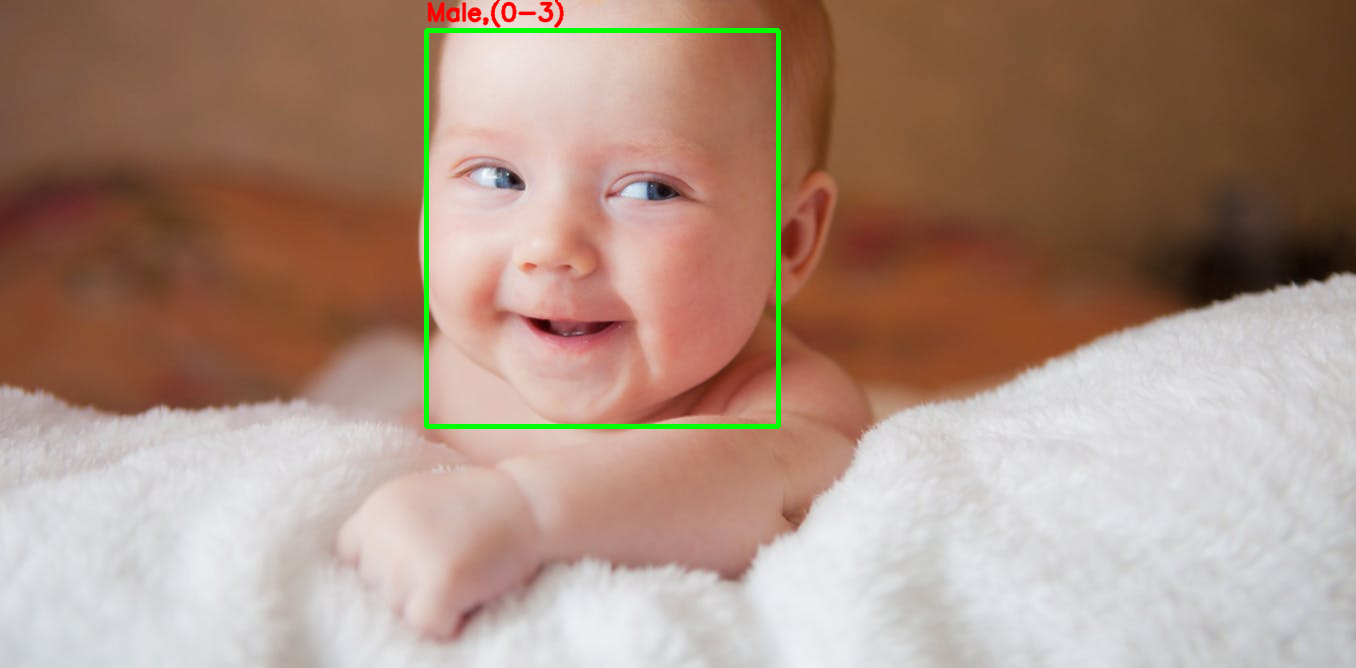

In [16]:
input = cv.imread("05.jpg")
output = age_gender_detector(input)
cv2_imshow(output)